In [9]:

from pathlib import Path
from typing import List, Optional, Callable, Sequence, Tuple

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# For visualization
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt

from torch.cuda.amp import GradScaler, autocast


print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
from python.VQVAE_v2 import *

In [11]:
BATCH_SIZE = 8192
EPOCHS = 50
LR = 5e-4
IN_CHANNELS = 3
EMBEDDING_DIM = 128  # The dimensionality of the embeddings
NUM_EMBEDDINGS = 512  # The size of the codebook (the "dictionary")
COMMITMENT_COST = 0.25

device = "cuda"
data_dir = "C:/Users/zphrfx/Desktop/hdk/VQVDB/data/vdb_cache/npy"


model = VQVAE(
    in_channels=IN_CHANNELS,
    embedding_dim=EMBEDDING_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    commitment_cost=COMMITMENT_COST,
).to(device)

npy_files = list(Path(data_dir).glob("*.npy"))
if not npy_files:
    raise ValueError(f"No .npy files found in /data/npy")

print(f"Found {len(npy_files)} .npy files")

vdb_dataset = VDBLeafDataset(npy_files=npy_files, include_origins=False, in_channels=IN_CHANNELS)

# Save the model state_dict
model_path = "C:/Users/zphrfx/Desktop/hdk/VQVDB/python/models/vqvae.pth"

# Visualize the reconstruction quality for a single example
save = torch.load(model_path, map_location=device)
model.load_state_dict(save["state_dict"])
model.eval()



Found 91 .npy files


VQVAE(
  (encoder): EncoderVec3(
    (net): Sequential(
      (0): Conv3d(3, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 128, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
      (6): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
  )
  (quantizer): VectorQuantizerEMA()
  (decoder): DecoderVec3(
    (net): Sequential(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
      (6): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(

Visualizing Reconstruction Quality for the full 8x8x8 block
Performing reconstruction...
Generating plots...


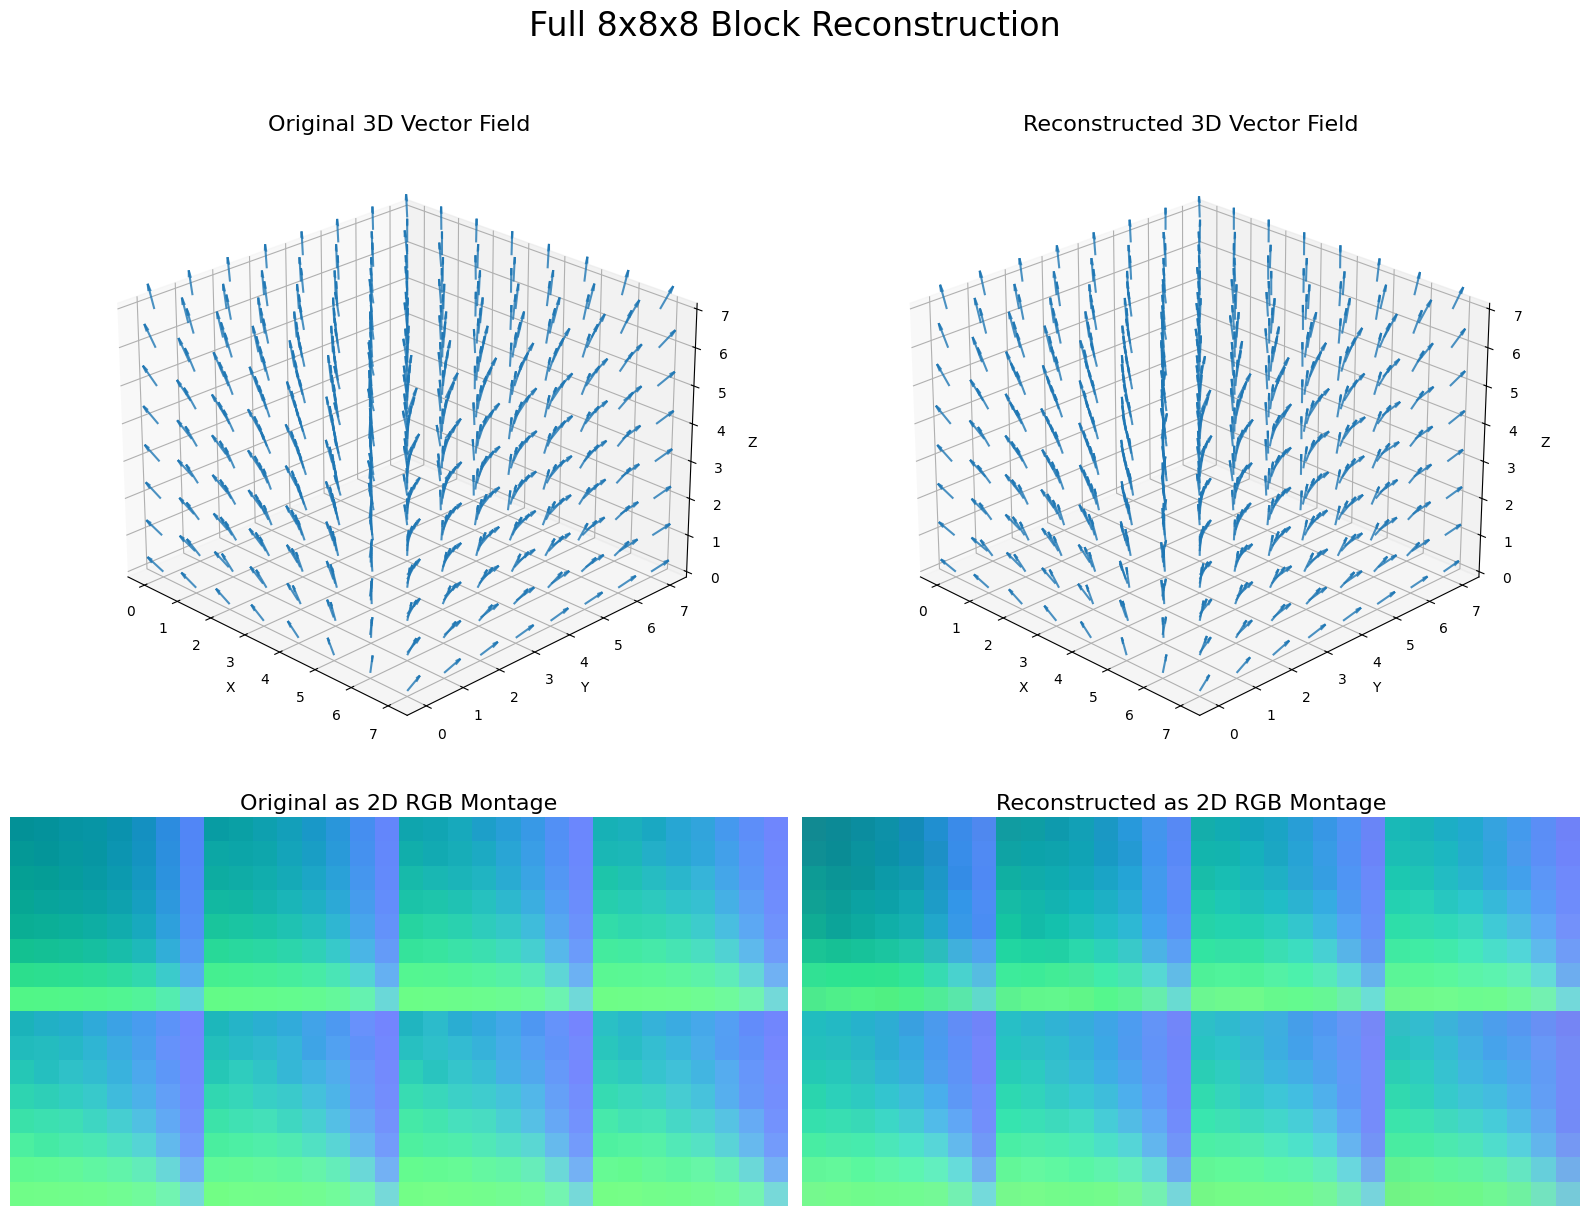

In [39]:
# --- 1. Load and Reconstruct Data (same as before) ---
print("Visualizing Reconstruction Quality for the full 8x8x8 block")

# Use a good example from your dataset
original_block = vdb_dataset[323].unsqueeze(0).to(device)

print("Performing reconstruction...")
model.eval() # Ensure model is in eval mode
with torch.no_grad():
    indices = model.encode(original_block)
    reconstructed_block = model.decode(indices)

# --- 2. Prepare Data for Plotting ---
# Convert to NumPy and permute from (C, D, H, W) to (D, H, W, C) for plotting
original_np = original_block.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()
reconstructed_np = reconstructed_block.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()

# --- 3. Helper function for the 2D RGB Montage ---
def create_rgb_montage(volume_data, grid_layout=(2, 4)):
    """
    Creates a 2D image montage from a 3D vector volume by mapping XYZ to RGB.
    """
    # Normalize vector components from [-1, 1] to color components [0, 1]
    rgb_volume = (volume_data * 0.5) + 0.5
    
    depth, height, width, _ = rgb_volume.shape
    rows, cols = grid_layout
    
    # Ensure the grid layout matches the number of slices
    if rows * cols != depth:
        raise ValueError("Grid layout does not match the number of slices in the volume.")
        
    montage = np.zeros((rows * height, cols * width, 3))
    
    for i in range(depth):
        row_idx = i // cols
        col_idx = i % cols
        
        slice_img = rgb_volume[i, :, :, :]
        
        # Place the slice into the correct position in the montage
        montage[row_idx * height:(row_idx + 1) * height,
                col_idx * width:(col_idx + 1) * width, :] = slice_img
                
    return montage

# --- 4. Plotting ---
print("Generating plots...")
fig = plt.figure(figsize=(16, 14))
fig.suptitle('Full 8x8x8 Block Reconstruction', fontsize=24)

# --- Top Row: 3D Quiver Plots ---

# Create the 3D coordinate grid for the arrows
grid_size = original_np.shape[0]
X, Y, Z = np.meshgrid(np.arange(grid_size), np.arange(grid_size), np.arange(grid_size))

# Extract vector components (U, V, W)
U_orig, V_orig, W_orig = original_np[:,:,:,0], original_np[:,:,:,1], original_np[:,:,:,2]
U_recon, V_recon, W_recon = reconstructed_np[:,:,:,0], reconstructed_np[:,:,:,1], reconstructed_np[:,:,:,2]

# Plot 1: Original 3D Quiver
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.set_title('Original 3D Vector Field', fontsize=16)
ax1.quiver(X, Y, Z, U_orig, V_orig, W_orig, length=0.6, normalize=False, alpha=0.8)
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
ax1.view_init(elev=25., azim=-45) # Set a good camera angle

# Plot 2: Reconstructed 3D Quiver
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.set_title('Reconstructed 3D Vector Field', fontsize=16)
ax2.quiver(X, Y, Z, U_recon, V_recon, W_recon, length=0.6, normalize=False, alpha=0.8)
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.view_init(elev=25., azim=-45) # Use the same camera angle

# --- Bottom Row: 2D RGB Montages ---

# Plot 3: Original 2D Montage
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Original as 2D RGB Montage', fontsize=16)
original_montage = create_rgb_montage(original_np)
ax3.imshow(original_montage)
ax3.axis('off')

# Plot 4: Reconstructed 2D Montage
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Reconstructed as 2D RGB Montage', fontsize=16)
reconstructed_montage = create_rgb_montage(reconstructed_np)
ax4.imshow(reconstructed_montage)
ax4.axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

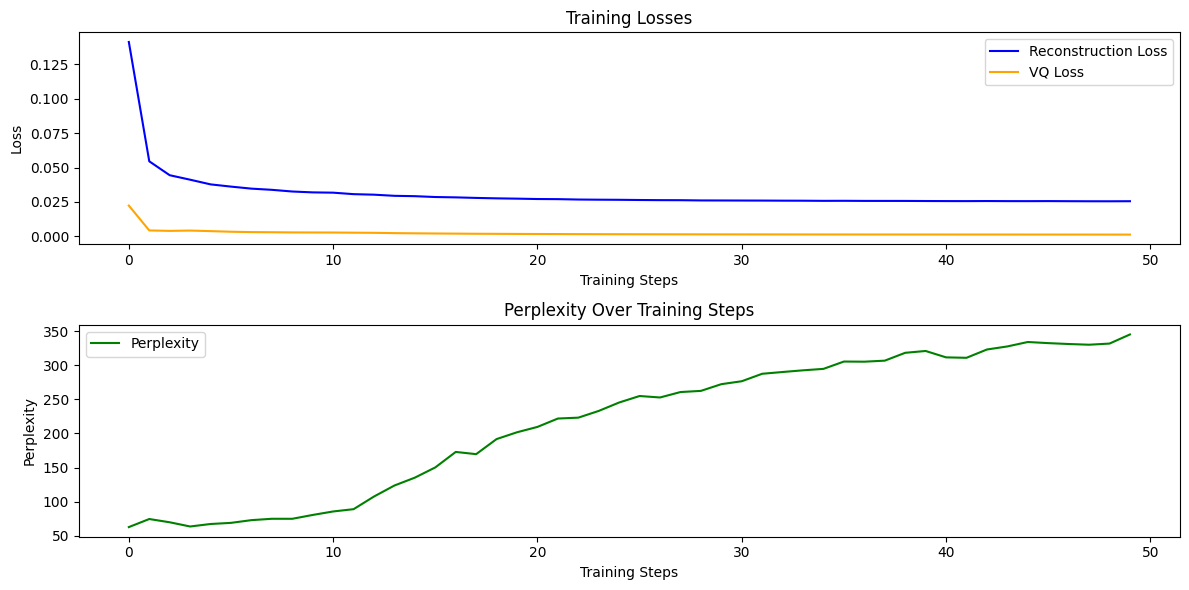

In [13]:

# plot losses and perplexity
rl = save['recon_loss_l']
vq_loss_l = save['vq_loss_l']
perplexity_l = save['perplexity_l']

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(rl, label='Reconstruction Loss', color='blue')
plt.plot(vq_loss_l, label='VQ Loss', color='orange')
plt.title('Training Losses')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(perplexity_l, label='Perplexity', color='green')
plt.title('Perplexity Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Perplexity')
plt.legend()
plt.tight_layout()
plt.show()


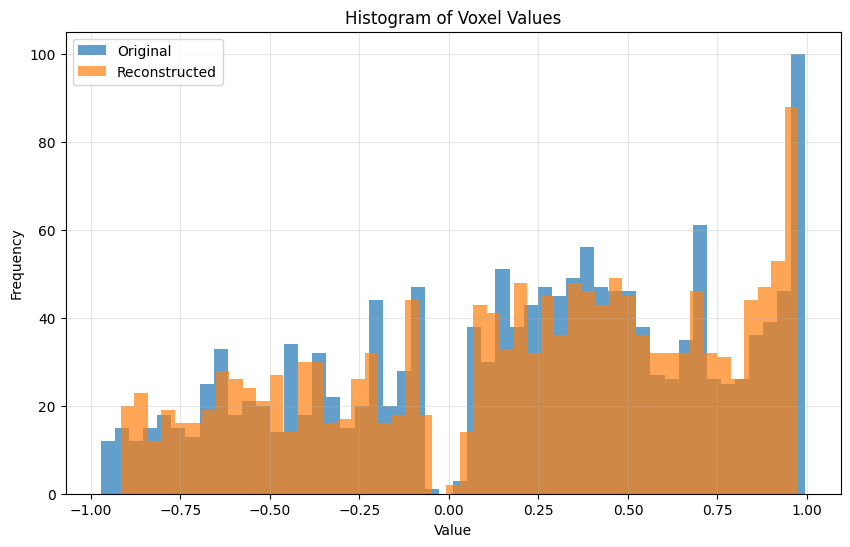

KL Divergence between original and reconstructed blocks: inf


In [40]:
plt.figure(figsize=(10, 6))
plt.hist(original_np.flatten(), bins=50, alpha=0.7, label='Original')
plt.hist(reconstructed_np.flatten(), bins=50, alpha=0.7, label='Reconstructed')
plt.title('Histogram of Voxel Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

from scipy.stats import entropy
def kl_divergence(p, q):
    """Compute KL divergence between two distributions."""
    p = p.flatten()
    q = q.flatten()
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    return entropy(p, q)
kl_div = kl_divergence(original_np , reconstructed_np)
print(f"KL Divergence between original and reconstructed blocks: {kl_div:.4f}")

PCA of the learned codebook vectors:


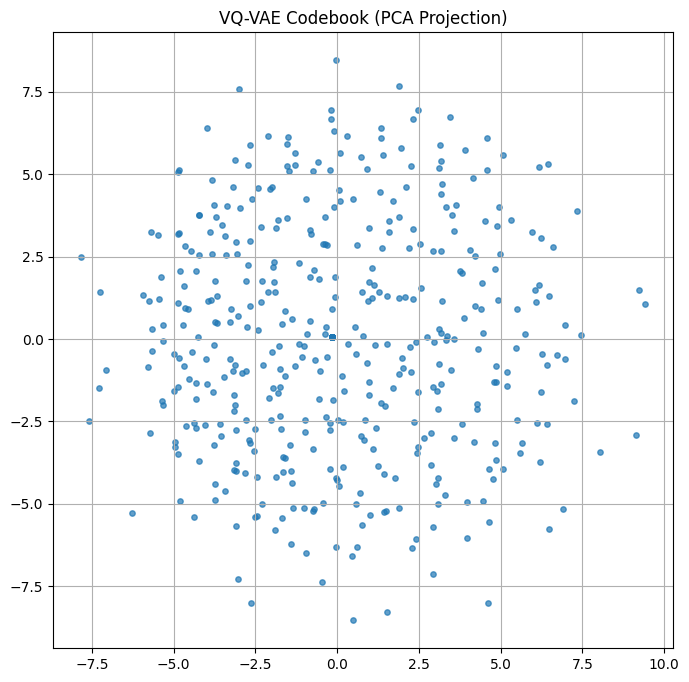


Calculating codebook usage across the entire dataset...


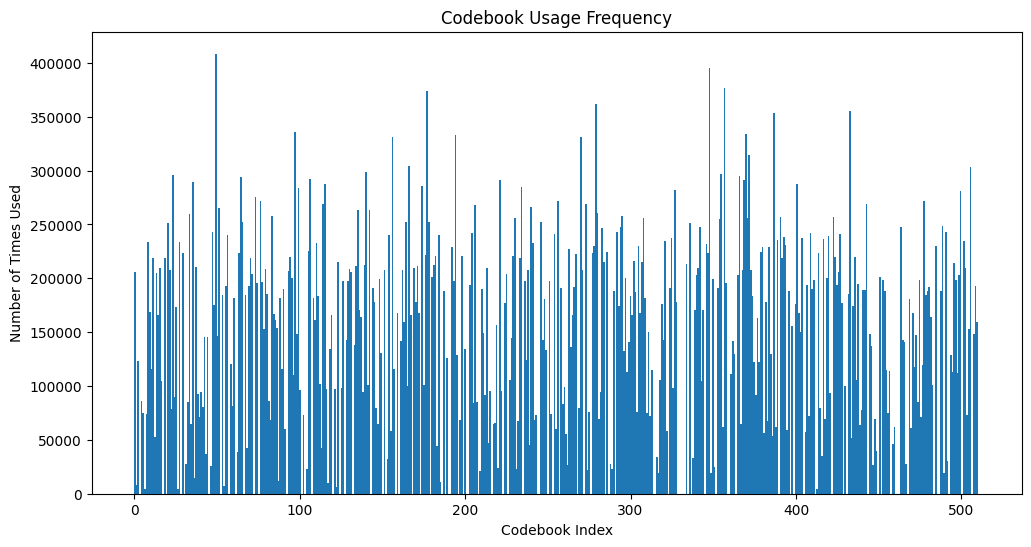

Number of 'dead' (unused) codes: 86 out of 512


In [15]:
print("PCA of the learned codebook vectors:")
codebook = model.quantizer.embedding.data.cpu()
pca = PCA(n_components=2)
codebook_2d = pca.fit_transform(codebook)
plt.figure(figsize=(8, 8))
plt.scatter(codebook_2d[:, 0], codebook_2d[:, 1], s=15, alpha=0.7)
plt.title('VQ-VAE Codebook (PCA Projection)')
plt.grid(True)
plt.show()

# --- Plot 2: Codebook Usage Histogram ---
# This is a powerful diagnostic. It requires running the encoder on the whole dataset.
print("\nCalculating codebook usage across the entire dataset...")
model.eval()
all_indices = []
full_loader = DataLoader(vdb_dataset, batch_size=BATCH_SIZE, shuffle=False)


with torch.no_grad():
    for data_batch in full_loader:
        data_batch = data_batch.to(device) # Move data to the same device as the model
        indices = model.encode(data_batch)
        all_indices.append(indices.cpu().numpy().flatten())

all_indices = np.concatenate(all_indices)

plt.figure(figsize=(12, 6))
plt.hist(all_indices, bins=NUM_EMBEDDINGS, range=(0, NUM_EMBEDDINGS-1))
plt.title('Codebook Usage Frequency')
plt.xlabel('Codebook Index')
plt.ylabel('Number of Times Used')
plt.show()

num_dead_codes = NUM_EMBEDDINGS - len(np.unique(all_indices))
print(f"Number of 'dead' (unused) codes: {num_dead_codes} out of {NUM_EMBEDDINGS}")

In [16]:
# --- Codebook Perplexity + Active-Code Ratio ---
counts = np.bincount(all_indices, minlength=NUM_EMBEDDINGS).astype(np.float64)
probs = counts / counts.sum()
nonzero = probs > 0
perplexity = np.exp(-(probs[nonzero] * np.log(probs[nonzero])).sum())
active_ratio = nonzero.mean()

print(f"Codebook perplexity: {perplexity:.2f}")
print(f"Active-code ratio  : {active_ratio*100:.1f}%")


Codebook perplexity: 365.62
Active-code ratio  : 83.2%


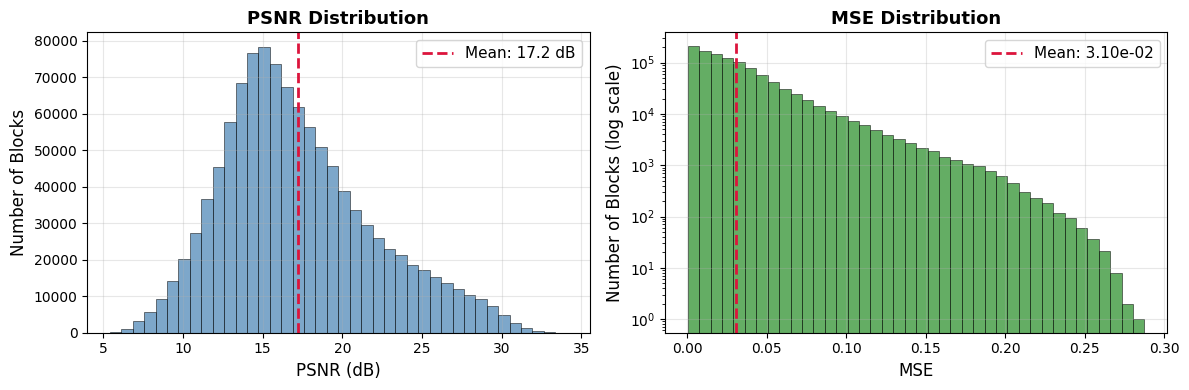

Reconstruction Quality Metrics:
Average PSNR: 17.20 dB
Average MSE: 3.10e-02
PSNR std: 4.78 dB
MSE std: 3.00e-02


In [19]:
from math import log10

def psnr(x, y, vmax=1.0):
    mse = torch.mean((x - y) ** 2).item()
    return 20 * log10(vmax) - 10 * log10(mse + 1e-12)

model.eval()
psnr_list, mse_list = [], []

with torch.no_grad():
    for batch in DataLoader(vdb_dataset, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        rec = model.decode(model.encode(batch))
        mse = ((batch - rec) ** 2).view(len(batch), -1).mean(dim=1)
        mse_list.extend(mse.cpu().numpy())
        psnr_list.extend([psnr(b, r) for b, r in zip(batch, rec)])

avg_psnr = np.mean(psnr_list)
avg_mse = np.mean(mse_list)

# Create publication-ready plots
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# PSNR Distribution
ax1.hist(psnr_list, bins=40, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax1.axvline(avg_psnr, color='crimson', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_psnr:.1f} dB')
ax1.set_xlabel('PSNR (dB)', fontsize=12)
ax1.set_ylabel('Number of Blocks', fontsize=12)
ax1.set_title('PSNR Distribution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=10)

# MSE Distribution
ax2.hist(mse_list, bins=40, alpha=0.7, color='forestgreen', edgecolor='black', linewidth=0.5)
ax2.axvline(avg_mse, color='crimson', linestyle='--', linewidth=2,
           label=f'Mean: {avg_mse:.2e}')
ax2.set_xlabel('MSE', fontsize=12)
ax2.set_ylabel('Number of Blocks (log scale)', fontsize=12)
ax2.set_title('MSE Distribution', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

print(f"Reconstruction Quality Metrics:")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average MSE: {avg_mse:.2e}")
print(f"PSNR std: {np.std(psnr_list):.2f} dB")
print(f"MSE std: {np.std(mse_list):.2e}")


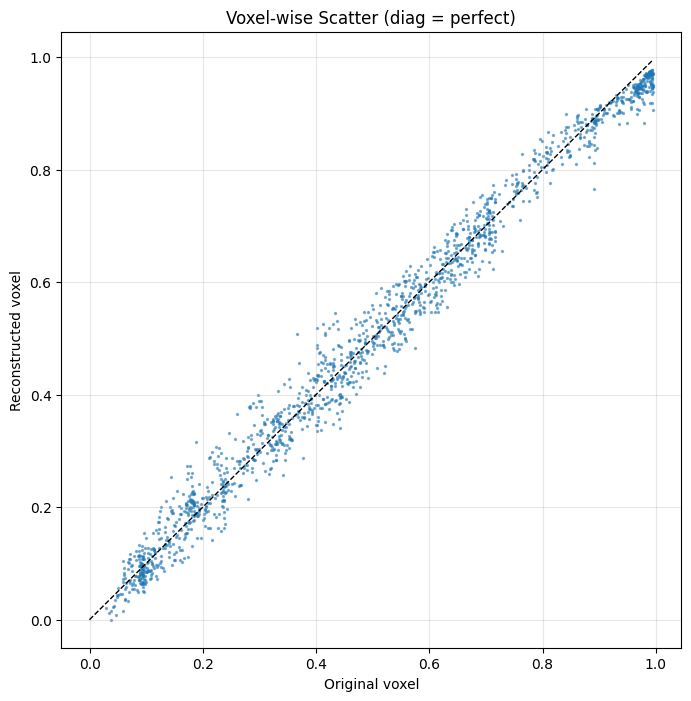

In [20]:
n_points = 100000
orig_sample = original_np.flatten()
recon_sample = reconstructed_np.flatten()
if len(orig_sample) > n_points:
    idx = np.random.choice(len(orig_sample), n_points, replace=False)
    orig_sample = orig_sample[idx]; recon_sample = recon_sample[idx]

plt.figure(figsize=(8,8))
plt.scatter(orig_sample, recon_sample, s=2, alpha=.5)
lims = [min(orig_sample.min(), recon_sample.min()),
        max(orig_sample.max(), recon_sample.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('Original voxel'); plt.ylabel('Reconstructed voxel')
plt.title('Voxel-wise Scatter (diag = perfect)')
plt.grid(True, alpha=.3); plt.show()


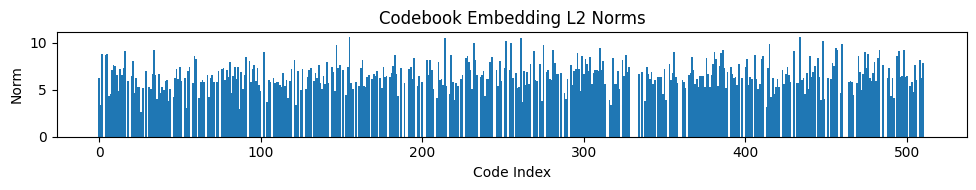

In [21]:
# --- L2 norm of each embedding vector ---
embed_norm = torch.linalg.norm(model.quantizer.embedding.data, dim=1).cpu().numpy()
plt.figure(figsize=(10,2))
plt.bar(range(NUM_EMBEDDINGS), embed_norm, width=1.0)
plt.title('Codebook Embedding L2 Norms'); plt.xlabel('Code Index'); plt.ylabel('Norm')
plt.tight_layout(); plt.show()


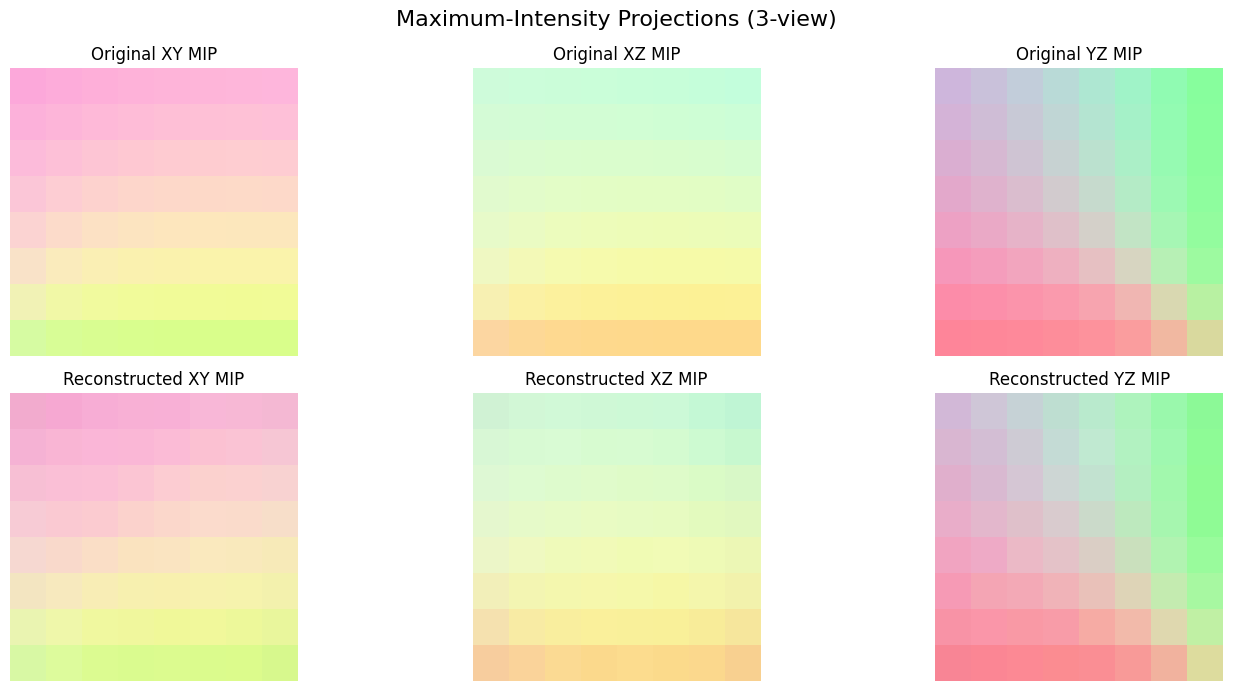

In [22]:
def mip(vol, axis):
    """Maximum-intensity projection along a single axis."""
    return vol.max(axis=axis)

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
views = [(0, 'XY MIP'),   # collapse Z
         (1, 'XZ MIP'),   # collapse Y
         (2, 'YZ MIP')]   # collapse X

for col, (axis_to_collapse, title) in enumerate(views):
    axes[0, col].imshow(mip(vector_to_rgb(original_np), axis=axis_to_collapse), cmap='viridis')
    axes[0, col].set_title(f'Original {title}')
    axes[0, col].axis('off')

    axes[1, col].imshow(mip(vector_to_rgb(reconstructed_np), axis=axis_to_collapse), cmap='viridis')
    axes[1, col].set_title(f'Reconstructed {title}')
    axes[1, col].axis('off')

plt.suptitle('Maximum-Intensity Projections (3-view)', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
# ---------- 1. Build a per-block latent vector ----------
model.eval()
latents, errs = [], []          # errs = optional colouring

with torch.no_grad():
    for batch in DataLoader(vdb_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False):
        batch = batch.to(device)
        
        idx = model.encode(batch).long()               # (B, Z, Y, X) indices
        emb = model.quantizer.embedding[idx.view(-1)]  # (B*Z*Y*X, C)
        emb = emb.view(*idx.shape, -1)                 # (B, Z, Y, X, C)
        mean_emb = emb.mean(dim=(1, 2, 3))             # (B, C)
        latents.append(mean_emb.cpu())
        
        # Optional: per-block MSE for coloured scatter
        rec = model.decode(idx)
        errs.append(((batch - rec) ** 2)
                    .view(len(batch), -1)
                    .mean(dim=1)
                    .cpu())

latents = torch.cat(latents, dim=0).numpy()   # (N, C)
errs    = torch.cat(errs, dim=0).numpy()      # (N,)

# ---------- 2. PCA to 2-D ----------
pca2 = FastICA(n_components=2, random_state=0)
latents_2d = pca2.fit_transform(latents)      # (N, 2)


sc = plt.scatter(latents_2d[:, 0],
                 latents_2d[:, 1],
                 c=errs,                 # <- set to None for uniform colour
                 cmap='viridis',
                 s=4,
                 alpha=0.8)
if sc.get_array() is not None:           # only if colouring by a value
    plt.colorbar(sc, label='Block MSE')

plt.title('Latent Space Sampling (PCA-2D, viridis)')
plt.xlabel('PC-1'); plt.ylabel('PC-2')
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 